In [1]:
!pip install -q eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


# 1. Library import

In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 2. Data Load

In [3]:
# 필요한 데이터 load
data_path = '/data/ephemeral/home/final_data.csv'
data = pd.read_csv(data_path)

# 기본 데이터의 shape 출력
print('Train data shape : ', data.shape)

Train data shape :  (1128094, 39)


In [4]:
# 2020년 이후 데이터만 사용
data = data[data['계약년'] >= 2020]
data

,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,target,is_test,지번주소,...,도로명_실거래가순위,도로_실거래가순위,동_실거래가순위,재건축,기준금리,CLI,자치구별 지하철 승객 수,아파트전세가격지수,학군,구_연평균_표준지공시지가
201009,개포더샵트리에,105.8064,202306,29,8,2021,개포로 311,240000.0,0,서울특별시 강남구 개포동 651-1,...,1127,77,48,0.0,3.25,72.9,161925782.0,69.3,1,1.740307e+07
201010,개포주공5단지,74.2500,202301,3,10,1983,삼성로4길 17,210000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,72.9,161925782.0,69.3,1,1.740307e+07
201011,개포주공5단지,61.1900,202302,5,12,1983,삼성로4길 17,199000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,73.0,161925782.0,69.2,1,1.740307e+07
201012,개포주공5단지,83.1700,202304,7,13,1983,삼성로4길 17,249000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,73.0,161925782.0,69.2,1,1.740307e+07
201013,개포주공5단지,83.1700,202304,29,10,1983,삼성로4길 17,277000.0,0,서울특별시 강남구 개포동 187,...,903,30,48,0.0,3.25,72.9,161925782.0,69.3,1,1.740307e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,신내우디안1단지,84.6500,202307,19,13,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,5.00,64.5,73185743.0,53.6,0,3.935362e+06
1128090,신내우디안1단지,84.6200,202307,25,12,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,4.50,63.0,73185743.0,53.4,0,3.935362e+06
1128091,신내우디안1단지,101.6500,202308,27,12,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,4.50,63.0,73185743.0,53.4,0,3.935362e+06
1128092,신내우디안1단지,84.9400,202309,2,18,2014,신내역로1길 85,NaN,1,서울특별시 중랑구 신내동 816,...,2695,274,280,0.0,4.50,63.2,73185743.0,53.4,0,3.935362e+06


In [5]:
# 칼럼 이름 변경 

data = data.rename(columns={
    "구_연평균_표준지공시지가" : "공시지가",
    "도로명_실거래가순위" : "신주소기준순위",
    "top아파트거리" : "동별최고가아파트까지의거리",
    "동_실거래가순위" : "행정동기준순위",
    "도로_실거래가순위" : "도로기준순위",
    "건물연식" : "건물나이"
    }
)

data.columns

Index(['아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test',
       '지번주소', '좌표X', '좌표Y', 'k-복도유형', 'k-단지분류', '주차대수', '구', '동', '계약년',
       '계약월', '계약년월일', '도로', '강남여부', '부촌여부', '상위아파트여부', '동별최고가아파트까지의거리',
       '브랜드명', '건물나이', '대장아파트거리', '인근지하철역개수', '신주소기준순위', '도로기준순위', '행정동기준순위',
       '재건축', '기준금리', 'CLI', '자치구별 지하철 승객 수', '아파트전세가격지수', '학군', '공시지가'],
      dtype='object')

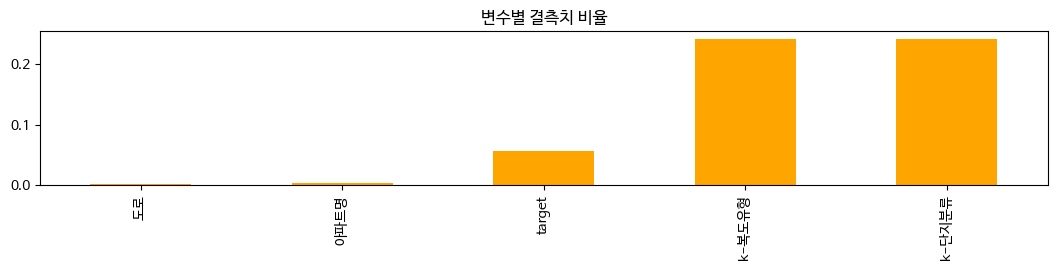

In [6]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = data.isnull().sum() / data.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [7]:
# 강남구, 서초구, 용산구, 송파구, 성동구만을 위한 고가형 모델을 따로 만드는 방식으로 접근
data.groupby('구')['target'].mean().sort_values(ascending=False)

구
강남구     197475.798214
서초구     193288.986893
용산구     175549.200341
송파구     141337.456353
성동구     125710.798121
광진구     111440.788636
마포구     107813.279425
동작구     101841.231439
양천구      95576.588567
영등포구     94533.132604
중구       91140.069152
강동구      89379.613799
종로구      86384.477184
서대문구     82651.918099
성북구      74022.882955
동대문구     73691.972413
강서구      71615.892676
은평구      66540.466296
관악구      65744.583153
강북구      59055.489344
노원구      57518.663856
구로구      57087.617957
중랑구      55637.215647
금천구      53718.703343
도봉구      49826.017843
Name: target, dtype: float64

# 3. 이상치 처리 > 진행 X
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

In [9]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(data.shape)

(165862, 39)


In [10]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [12]:
# 이상치 제거 후 자치구별 타겟값 
data.groupby('구')['target'].mean().sort_values(ascending=False)

구
강남구     197475.798214
서초구     193288.986893
용산구     175549.200341
송파구     141337.456353
성동구     125710.798121
광진구     111440.788636
마포구     107813.279425
동작구     101841.231439
양천구      95576.588567
영등포구     94533.132604
중구       91140.069152
강동구      89379.613799
종로구      86384.477184
서대문구     82651.918099
성북구      74022.882955
동대문구     73691.972413
강서구      71615.892676
은평구      66540.466296
관악구      65744.583153
강북구      59055.489344
노원구      57518.663856
구로구      57087.617957
중랑구      55637.215647
금천구      53718.703343
도봉구      49826.017843
Name: target, dtype: float64

In [13]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(data.shape)

(165862, 39)


In [14]:
# 또한, train data만 제거되었습니다.
data['is_test'].value_counts()

0    156590
1      9272
Name: is_test, dtype: int64

# 4. Upsampling

In [15]:
# 데이터 수가 적은 높은 실거래가의 데이터를 복사하여 넣어줌
df_high_cases1 = data[data['target'] >= 1300000]
data = pd.concat([data, df_high_cases1])
data = pd.concat([data, df_high_cases1])

df_high_cases2 = data[data['target'] >= 1000000 & (data['target'] < 1300000)]
data = pd.concat([data, df_high_cases2])
data = pd.concat([data, df_high_cases2])

In [16]:
data.shape

(479060, 39)

# 5. Model Training

In [17]:
dt_train = data.query('is_test==0').reset_index()
dt_test = data.query('is_test==1').reset_index()

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(469788, 39) (9272, 39)


In [18]:
# 사용할 컬럼만 추출 아파트명 추가
final_cols = ['신주소기준순위', '전용면적', '계약년', '아파트명',
                  '계약월', '도로기준순위', '좌표X', '좌표Y', '건축년도',
                  '부촌여부', '상위아파트여부', '대장아파트거리', '행정동기준순위', '구',
                  '주차대수', '인근지하철역개수', '브랜드명', '건물나이', '계약년월일',
                  '동별최고가아파트까지의거리', 'target','재건축', '기준금리', 'CLI',
                  '자치구별 지하철 승객 수', '공시지가', '아파트전세가격지수', '학군'
                  ]

dt_train = dt_train[final_cols]
dt_test = dt_test[final_cols]

## 5.1 고가용/저가용 모델을 위한 학습데이터 분리

In [19]:
high_list = ['서초구', '강남구', '용산구', '송파구', '성동구']

# train
high_train = dt_train[dt_train['구'].isin(high_list)]
low_train = dt_train[~dt_train['구'].isin(high_list)]

# test
high_test = dt_test[dt_test['구'].isin(high_list)]
low_test = dt_test[~dt_test['구'].isin(high_list)]

In [20]:
print(high_train.shape, low_train.shape)

(97422, 28) (372366, 28)


## 5.2 범주형 변수 Encoding

- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [21]:
numerical_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        numerical_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("수치형 변수:", numerical_columns_v2)
print("범주형 변수:", categorical_columns_v2)

수치형 변수: ['신주소기준순위', '전용면적', '계약년', '계약월', '도로기준순위', '좌표X', '좌표Y', '건축년도', '부촌여부', '상위아파트여부', '대장아파트거리', '행정동기준순위', '주차대수', '인근지하철역개수', '건물나이', '계약년월일', '동별최고가아파트까지의거리', 'target', '재건축', '기준금리', 'CLI', '자치구별 지하철 승객 수', '공시지가', '아파트전세가격지수', '학군']
범주형 변수: ['아파트명', '구', '브랜드명']


### 5.2.1. 고가형 모델 학습 데이터

In [22]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders_high = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()
    
    # 모든 데이터를 문자열로 변환
    all_values = pd.concat([high_train[col], high_test[col]], axis=0).astype(str)
    
    # Label-Encoding을 fit
    lbl.fit(all_values)
    
    # 변환 적용
    high_train[col] = lbl.transform(high_train[col].astype(str))
    high_test[col] = lbl.transform(high_test[col].astype(str))
    
    # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.
    label_encoders_high[col] = lbl

100%|██████████| 3/3 [00:00<00:00, 57.99it/s]


In [23]:
high_train.head(1)

,신주소기준순위,전용면적,계약년,아파트명,계약월,도로기준순위,좌표X,좌표Y,건축년도,부촌여부,...,계약년월일,동별최고가아파트까지의거리,target,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
0,1127,105.8064,2023,85,6,77,127.056394,37.484892,2021,0,...,20230629,500.0,240000.0,0.0,3.25,72.9,161925782.0,1.740307e+07,69.3,1


### 5.2.2. 저가형 모델 학습 데이터

In [24]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders_low = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()
    
    # 모든 데이터를 문자열로 변환
    all_values = pd.concat([low_train[col], low_test[col]], axis=0).astype(str)
    
    # Label-Encoding을 fit
    lbl.fit(all_values)
    
    # 변환 적용
    low_train[col] = lbl.transform(low_train[col].astype(str))
    low_test[col] = lbl.transform(low_test[col].astype(str))
    
    # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.
    label_encoders_low[col] = lbl

100%|██████████| 3/3 [00:00<00:00, 15.97it/s]


In [25]:
low_train.head(1)

,신주소기준순위,전용면적,계약년,아파트명,계약월,도로기준순위,좌표X,좌표Y,건축년도,부촌여부,...,계약년월일,동별최고가아파트까지의거리,target,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
856,2200,59.99,2022,155,12,205,127.1731,37.572621,2020,0,...,20221229,500.0,55000.0,0.0,3.25,72.9,161925782.0,6310000.0,69.1,1


## 5.3 Model Training

### 5.3.1. 고가형 모델 학습

In [26]:
# Target과 독립변수들을 분리해줍니다.
X_train_high_all = high_train.drop(['target', '계약년월일'], axis=1)
y_train_high_all = high_train['target']

# Custom validation split - 최근 20% 데이터를 validation set으로 나눔
high_train = high_train.sort_values('계약년월일')
cut = int(len(high_train)*0.9)
train_split = high_train[:cut]
valid_split = high_train[cut:]

X_train_high = train_split.drop(['target', '계약년월일'], axis=1)
y_train_high = train_split['target']
X_val_high = valid_split.drop(['target', '계약년월일'], axis=1)
y_val_high = valid_split['target']

lgb_params_high = {
            'n_estimators': 2048,          
            'force_col_wise': True
            }

model_high = LGBMRegressor(**lgb_params_high)

In [27]:
# 모델 학습 및 평가
model_high.fit(X_train_high, y_train_high)
pred_high = model_high.predict(X_val_high)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'Validation RMSE: {mean_squared_error(y_val_high, pred_high, squared=False)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2503
[LightGBM] [Info] Number of data points in the train set: 87679, number of used features: 26
[LightGBM] [Info] Start training from score 165419.277455
Validation RMSE: 21628.46360614712


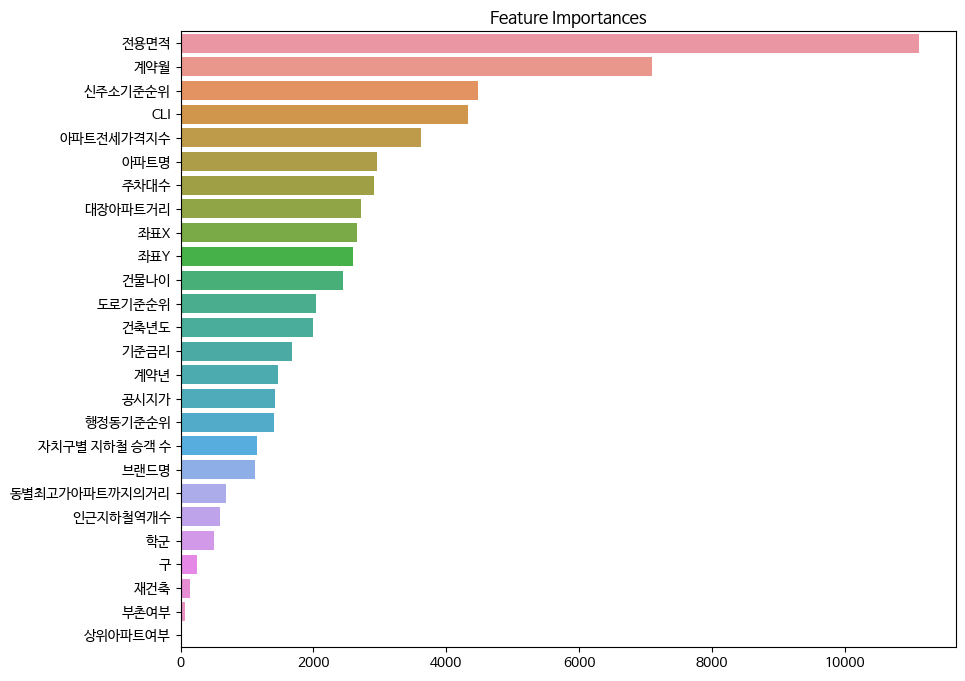

In [28]:
# 고가형 모델의 feature importance를 시각화해봅니다.
importances_high = pd.Series(model_high.feature_importances_, index=list(X_train_high.columns))
importances_high = importances_high.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_high, y=importances_high.index)
plt.show()

### 5.3.2 저가형 모델 학습

In [29]:
# Target과 독립변수들을 분리해줍니다.
X_train_low_all = low_train.drop(['target', '계약년월일'], axis=1)
y_train_low_all = low_train['target']

# Custom validation split - 최근 20% 데이터를 validation set으로 나눔
low_train = low_train.sort_values('계약년월일')
cut = int(len(low_train)*0.9)
train_split = low_train[:cut]
valid_split = low_train[cut:]

X_train_low = train_split.drop(['target', '계약년월일'], axis=1)
y_train_low = train_split['target']
X_val_low = valid_split.drop(['target', '계약년월일'], axis=1)
y_val_low = valid_split['target']

# LGBM 파라미터 설정
lgb_params_low = {
            'n_estimators': 2048,          
            'force_col_wise': True
            }

model_low = LGBMRegressor(**lgb_params_low)

In [30]:
# 모델 학습 및 평가
model_low.fit(X_train_low, y_train_low)
pred_row = model_low.predict(X_val_low)

# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'Validation RMSE: {mean_squared_error(y_val_low, pred_row, squared=False)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 2639
[LightGBM] [Info] Number of data points in the train set: 335129, number of used features: 24
[LightGBM] [Info] Start training from score 73419.339183
Validation RMSE: 9695.083666061702


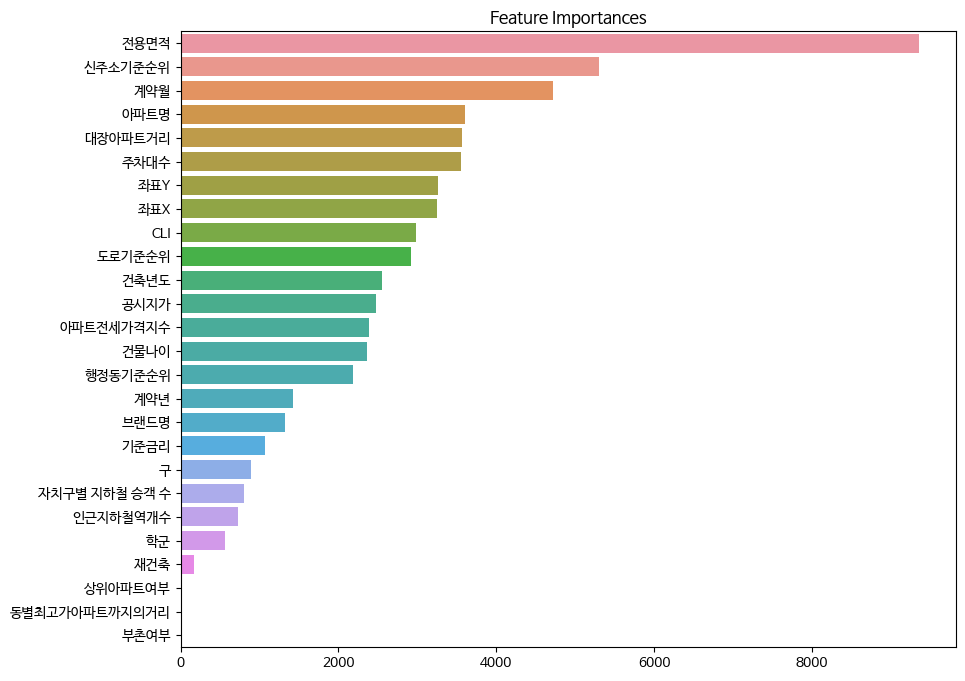

In [31]:
# 저가형 모델의 feature importance를 시각화해봅니다.
importances_low = pd.Series(model_low.feature_importances_, index=list(X_train_low.columns))
importances_low = importances_low.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances_low, y=importances_low.index)
plt.show()

# 6. Inference

In [32]:
 # test dataset에 대한 inference를 진행해보겠습니다.
dt_test.head(2)

,신주소기준순위,전용면적,계약년,아파트명,계약월,도로기준순위,좌표X,좌표Y,건축년도,부촌여부,...,계약년월일,동별최고가아파트까지의거리,target,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
0,927,79.9700,2023,개포6차우성,7,35,127.057210,37.476763,1987,0,...,20230726,500.0,NaN,0.0,4.5,62.6,73185743.0,1.740307e+07,52.7,1
1,1127,108.2017,2023,개포더샵트리에,8,77,127.056394,37.484892,2021,0,...,20230815,500.0,NaN,0.0,4.5,62.8,73185743.0,1.740307e+07,53.1,1


## 6.1 고가용 모델 추론

In [33]:
# 고가용 모델 추론을 위한 데이터
X_test_high = high_test.drop(['target', '계약년월일'], axis=1)
X_test_high.head(2)

,신주소기준순위,전용면적,계약년,아파트명,계약월,도로기준순위,좌표X,좌표Y,건축년도,부촌여부,...,브랜드명,건물나이,동별최고가아파트까지의거리,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
0,927,79.9700,2023,84,7,35,127.057210,37.476763,1987,0,...,23,36,500.0,0.0,4.5,62.6,73185743.0,1.740307e+07,52.7,1
1,1127,108.2017,2023,85,8,77,127.056394,37.484892,2021,0,...,7,2,500.0,0.0,4.5,62.8,73185743.0,1.740307e+07,53.1,1


In [34]:
# 고가형 모델 추론 결과
high_pred = model_high.predict(X_test_high)
high_pred

array([192427.76151075, 248870.86991828, 327213.05693157, ...,
        99207.14570265,  99578.753222  ,  96760.08941163])

## 6.2 저가용 모델 추론

In [35]:
# 저가용 모델 추론을 위한 데이터
X_test_low = low_test.drop(['target', '계약년월일'], axis=1)
X_test_low.head(2)

,신주소기준순위,전용면적,계약년,아파트명,계약월,도로기준순위,좌표X,좌표Y,건축년도,부촌여부,...,브랜드명,건물나이,동별최고가아파트까지의거리,재건축,기준금리,CLI,자치구별 지하철 승객 수,공시지가,아파트전세가격지수,학군
343,2200,49.82,2023,155,7,205,127.1731,37.572621,2020,0,...,2,3,500.0,0.0,5.0,64.8,73185743.0,5.916253e+06,53.6,0
344,2200,49.82,2023,155,7,205,127.1731,37.572621,2020,0,...,2,3,500.0,0.0,5.0,64.6,73185743.0,5.916253e+06,53.7,0


In [36]:
# 저가형 모델 추론 결과
low_pred = model_low.predict(X_test_low)
low_pred

array([55354.78906683, 55354.78906683, 55810.93404217, ...,
       84734.86200882, 76741.18993323, 78070.79117097])

## 7. Output File Save

In [37]:
dt_test['target'] = 0

# 고가형 모델 추론 결과 넣기
dt_test.loc[high_test.index, 'target'] = high_pred

# 저가형 모델 추론 결과 넣기
dt_test.loc[low_test.index, 'target'] = low_pred

In [38]:
# 최종 추론 결과 확인
dt_test['target'].astype(int)

0       192427
1       248870
2       327213
3       291072
4       235264
         ...  
9267     77163
9268     77169
9269     84734
9270     76741
9271     78070
Name: target, Length: 9272, dtype: int64

In [39]:
# 추론 결과 저장
dt_test['target'].astype(int).to_csv('../output_ensemble.csv', index=False)